In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import spherical_volume, volume_fourier, volume_comp, mip_z,create_mask
from src.projection import project_spatial, project, rotate
from src.interpolate import *
import jax

Generate the volume

Text(0.5, 1.0, 'Volume_comp MIP')

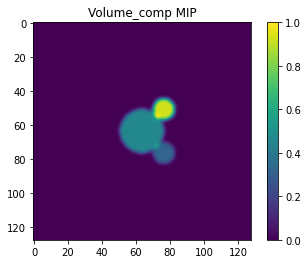

In [3]:
nx = 128
shape = np.array([nx,nx,nx])
dimensions = np.array([20,20,20])

# A volume with components
centres = np.array([[0,0,0], [2, 2, 0], [2, -2, 0]])
radii = np.array([2, 1, 1])
intensities = np.array([10,7,20])

vol = jnp.array(volume_comp(shape, dimensions, centres, radii, intensities, True))
vol_fourier, X, Y, Z, _, _, _ = volume_fourier(jnp.fft.ifftshift(vol), dimensions)

mip_z(vol)
#plt.imshow(v[:,:,int(np.floor(v.shape[2]/2))])
plt.colorbar()
plt.title('Volume_comp MIP')

Apply Fourier mask to volume to work with the lower frequencies only

In [4]:
mask = create_mask(X, Y, Z, (0,0,0),1)
x_size = np.sum(mask[:,0,0])
y_size = np.sum(mask[0,:,0])
z_size = np.sum(mask[0,0,:])

vol_fourier_masked = vol_fourier[mask == 1]
vol_fourier_masked.shape
print(x_size*y_size*z_size)

68921.0


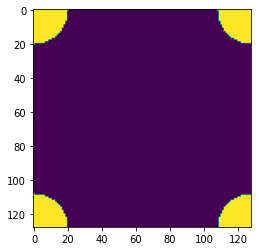

In [5]:
mip_z(mask)

Get x_grid etc to calculate projections in Fourier

In [6]:
x_freq = X[0,:,0]
y_freq = Y[:,0,0]
z_freq = Z[0,0,:]

x_grid = np.array([x_freq[1], len(x_freq)])
y_grid = np.array([y_freq[1], len(y_freq)])
z_grid = np.array([z_freq[1], len(z_freq)])

Generate projections (in Fourier domain)

In [7]:
@jax.jit
def slice_func(v, angles):
    projection, _ = project(mask * v, x_grid, y_grid, z_grid, angles)
    return projection

@jax.jit
def slice_func_array(v, angles):    
    return jax.vmap(slice_func, in_axes = (None, 0))(v, angles)

In [8]:
N = 1000
angles_true = jnp.array(np.random.rand(N,3))*jnp.pi*2
start = time.time()
imgs = slice_func_array(vol_fourier, angles_true)
print(time.time()-start)

1.7464470863342285


In [9]:
jnp.sum(mask[:,:,0])

DeviceArray(1257., dtype=float64)

In [10]:
nx*nx

16384

Loss function given volume and angles, for one image and for many (batches of images). We have a separate loss function for each angles-image pair.

In [11]:
def l2sq(x):
    return jnp.real(jnp.sum(jnp.conj(x)*x))

@jax.jit
def loss_func(v, angles, img):
    #return 1/(2* nx*nx) * l2sq(slice_func(v, angles) - img)
    return 1/(2* 1257) * l2sq(slice_func(v, angles) - img)   #1257 = number of pixels in mask at z=0


@jax.jit
def loss_func_batched(v, angles, imgs):
    return jax.vmap(loss_func, in_axes = (None, 0, 0))(v, angles, imgs)

And the gradients of the above, with respect to angles

In [12]:
@jax.jit
def grad_loss_angles(v, angles, img):
    return jax.grad(loss_func, argnums = 1)(v, angles, img)

@jax.jit
def grad_loss_angles_batched(v, angles, imgs):
    return jax.vmap(grad_loss_angles, in_axes = (None, 0, 0))(v, angles, imgs)

In [13]:
start = time.time()
ll = loss_func_batched(vol_fourier, angles_true, imgs)
print(time.time()-start)
print(ll.shape)

1.049182415008545
(1000,)


In [14]:
start = time.time()
dl = grad_loss_angles(vol_fourier, angles_true[0], imgs[0])
print(time.time()-start)
print(dl.shape)

2.3359460830688477
(3,)


In [15]:
start = time.time()
dl = grad_loss_angles_batched(vol_fourier, angles_true, imgs)
print(time.time()-start)
print(dl.shape)

1.6517019271850586
(1000, 3)


Gradients with respect to volume pixels, over all (or a batch of) images

In [16]:
@jax.jit
def grad_loss_volume(v, angles, img):
    return jax.grad(loss_func)(v, angles, img)

@jax.jit
def grad_loss_volume_batched(v, angles, imgs):
    return 1/N * jnp.sum(jax.vmap(grad_loss_volume, in_axes = (None, 0, 0))(v, angles, imgs), axis=0)

In [17]:
start = time.time()
ll = grad_loss_volume(vol_fourier, angles_true[0], imgs[0])
print(time.time()-start)
print(ll.shape)

0.9960861206054688
(128, 128, 128)


In [18]:
start = time.time()
ll = grad_loss_volume_batched(vol_fourier, angles_true, imgs)
print(time.time()-start)
print(ll.shape)

RuntimeError: Resource exhausted: Out of memory while trying to allocate 269287424240 bytes.

## Gradient descent with respect to angles

In [19]:
alpha = 0.00000001
a = jnp.array(np.random.rand(N, 3)*np.pi*2)
a = angles_true + 0.01*a
N_iter = 1000

for i in range(N_iter):
        
    if jnp.mod(i,10) == 0:
    #print(i)
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(vol_fourier, a, imgs))))
        
    a = a - alpha * jnp.conj(grad_loss_angles_batched(vol_fourier, a, imgs))
    
max_err = jnp.mean(jnp.abs(a - angles_true))
print("mean(a-a_true) = " + str(max_err))

Iter 0: mean loss = 1391.8817938509485
Iter 10: mean loss = 1068.7013356273033
Iter 20: mean loss = 831.5165616332197
Iter 30: mean loss = 656.7615007788031
Iter 40: mean loss = 526.8917739317416
Iter 50: mean loss = 429.6147621813882
Iter 60: mean loss = 355.8934256913711
Iter 70: mean loss = 299.2802198257457
Iter 80: mean loss = 255.2843074287552
Iter 90: mean loss = 220.66100565137504
Iter 100: mean loss = 193.0640629529868
Iter 110: mean loss = 170.7774327635779
Iter 120: mean loss = 152.56403161308182
Iter 130: mean loss = 137.4976456472868
Iter 140: mean loss = 124.89680398735503
Iter 150: mean loss = 114.2479182047043
Iter 160: mean loss = 105.16175018670424
Iter 170: mean loss = 97.33191459189435
Iter 180: mean loss = 90.52737824271405
Iter 190: mean loss = 84.56594634027937
Iter 200: mean loss = 79.29959301052443
Iter 210: mean loss = 74.61889836880239
Iter 220: mean loss = 70.43090294685052
Iter 230: mean loss = 66.6582798073133
Iter 240: mean loss = 63.241222552963556
Iter 

In [20]:
max_err = jnp.max(jnp.abs(a - angles_true))
print("max(a-a_true) = " + str(max_err))

max(a-a_true) = 0.060126538248225


## Gradient descent with respect to volume

In [24]:
v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))*jnp.max(jnp.abs(imgs[0])) * mask
#v0 = vol_fourier + 0.1*v * mask
alpha = 100000
batch_size = 2
N_iter = 1000 * 10 *5

v = v0
for i in range(N_iter):
    
    idx = np.random.default_rng().choice(N, size=batch_size, replace = False)
    
    if jnp.mod(i,300) == 0:
        #print(i)
        print("Iter " + str(i) + ": mean loss = " + str(jnp.mean(loss_func_batched(v, angles_true[idx], imgs[idx]))))
        
    v = v - alpha * jnp.conj(grad_loss_volume_batched(v, angles_true[idx], imgs[idx]))
    
jnp.max(jnp.abs(v - vol_fourier))

Iter 0: mean loss = 9316857.636414424
Iter 300: mean loss = 2171694.976406339
Iter 600: mean loss = 1006588.3017039641
Iter 900: mean loss = 609362.7683832434
Iter 1200: mean loss = 322484.33486295876
Iter 1500: mean loss = 210617.13442466655
Iter 1800: mean loss = 133943.78004650582
Iter 2100: mean loss = 104224.27643195254
Iter 2400: mean loss = 65112.24169287835
Iter 2700: mean loss = 48274.33452873051
Iter 3000: mean loss = 28451.527524020836
Iter 3300: mean loss = 25501.929049477487
Iter 3600: mean loss = 20024.405119773415
Iter 3900: mean loss = 19963.555130467397
Iter 4200: mean loss = 16892.251865640577
Iter 4500: mean loss = 14762.800025085426
Iter 4800: mean loss = 9561.650848072657
Iter 5100: mean loss = 8663.999331108102
Iter 5400: mean loss = 5623.039102165514
Iter 5700: mean loss = 4375.543557627756
Iter 6000: mean loss = 2415.414820131713
Iter 6300: mean loss = 3239.469230544065
Iter 6600: mean loss = 2438.586103104055
Iter 6900: mean loss = 2902.6861637138054
Iter 7200:

DeviceArray(113.00244276, dtype=float64)

In [26]:
jnp.max(jnp.abs(v - vol_fourier))

DeviceArray(113.00244276, dtype=float64)

Text(0.5, 1.0, 'Volume_comp MIP')

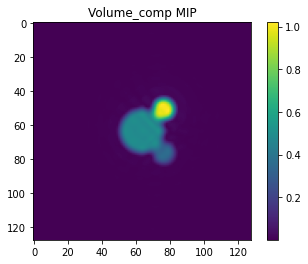

In [31]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v))))
plt.colorbar()
plt.title('Volume_comp MIP')

Text(0.5, 1.0, 'Volume_comp MIP')

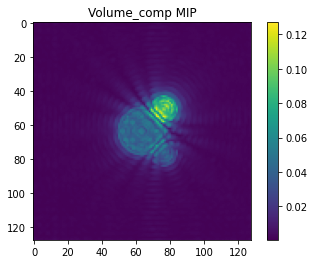

In [32]:
mip_z(jnp.abs(vol-jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v)))))
plt.colorbar()
plt.title('Volume_comp MIP')

In [ ]:
imgs.shape